<a href="https://colab.research.google.com/github/OscarBedford/MLCourse_Weekly_Exercises/blob/main/Machine_Learning_Course_Week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset A (classification): for the first set of 5 small programming tasks use the Oasis dataset provided by the nilearn package, which can be downloaded using the code below. This is a dataset of structural brain scans (aka voxel-based morphometry) for male and female individuals.


In [ ]:
# Importing the packages and the data

from nilearn import datasets
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from nilearn.maskers import NiftiLabelsMasker

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_yeo_2011()
masker = NiftiLabelsMasker(labels_img=yeo['thick_17'],
standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F',
dtype=int) #gives 1 for females and 0 for males

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/struct.py:774: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


1. Use sklearn.linear_model.LogisticRegression(hyperparameter set to 1.0) trained on all 17 input_variables to perform uncertainty estimation. Draw 200 bootstrap samples from the dataset, and for each of these bootstrap datasets, fit your model on all 100 subjects (you will train 200 models). Plot the distribution of model parameters(.coef_)using pyplot.boxplot(). The distribution of the model parameters should be on the y-axis and 17 input variables on the x axis; the mean of each box is the original point estimate of the model coefficient (i.e., the original dataset, not the bootstrap data).

In [ ]:
# Let's take a look at the shape of the features
print (input_variables.shape)

(100, 17)


Looks like we have 100 instances and 17 features. Let's get the scaler ready without using it right away on the raw data. It's important that we run it on every bootstrap sample independently, as if each one was a real separate sample. In other words, we need to keep the pipeline the same for both the original data and the bootstrapped samples.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
# Let's create one bootstrap sample containing 100 observations (like the original sample) just to make sure we have the right size
boot = resample(input_variables, replace=True, n_samples=100)
print (boot.shape)

(100, 17)


Looks like the size of our "boot" sample is correct, because it is the same as the original data. But we will need 200 of these samples, so let's make use of a for loop to create them iteratively:

In [ ]:
# Setting the number of iterations
n_iterations = 200
# Pre-allocating the array where the coefficients of the 200 models will be appended
coefficients = []

for i in range(n_iterations):
    X_train = resample(input_variables, replace=True, n_samples=100) # X_train is the given bootstrap sample in the current iteration
    X_train = scaler.fit_transform(X_train) # Here we run the scaler on every iteration
    y_train = output_variable # y_train will remain the same as the original sample across iterations
    LR_boot = LogisticRegression(max_iter=1e4).fit(X_train,y_train) # We fit the LR model to the current bootstrap sample
    coefficients.append(LR_boot.coef_) # Store the coefficients in the "coefficients" array
    score = LR_boot.score(X_train, y_train) # We will also export the score for each bootstrap model (...)
    print('Accuracy: %.3f (%.3f)' % ((score), std(score))) # (...) and we will print it to make sure every model is different

Accuracy: 0.710 (0.000)
Accuracy: 0.680 (0.000)
Accuracy: 0.700 (0.000)
Accuracy: 0.700 (0.000)
Accuracy: 0.680 (0.000)
Accuracy: 0.720 (0.000)
Accuracy: 0.690 (0.000)
Accuracy: 0.700 (0.000)
Accuracy: 0.730 (0.000)
Accuracy: 0.650 (0.000)
Accuracy: 0.620 (0.000)
Accuracy: 0.640 (0.000)
Accuracy: 0.670 (0.000)
Accuracy: 0.730 (0.000)
Accuracy: 0.710 (0.000)
Accuracy: 0.680 (0.000)
Accuracy: 0.680 (0.000)
Accuracy: 0.700 (0.000)
Accuracy: 0.700 (0.000)
Accuracy: 0.650 (0.000)
Accuracy: 0.670 (0.000)
Accuracy: 0.660 (0.000)
Accuracy: 0.710 (0.000)
Accuracy: 0.670 (0.000)
Accuracy: 0.720 (0.000)
Accuracy: 0.710 (0.000)
Accuracy: 0.670 (0.000)
Accuracy: 0.750 (0.000)
Accuracy: 0.730 (0.000)
Accuracy: 0.720 (0.000)
Accuracy: 0.660 (0.000)
Accuracy: 0.710 (0.000)
Accuracy: 0.730 (0.000)
Accuracy: 0.680 (0.000)
Accuracy: 0.690 (0.000)
Accuracy: 0.710 (0.000)
Accuracy: 0.710 (0.000)
Accuracy: 0.700 (0.000)
Accuracy: 0.750 (0.000)
Accuracy: 0.700 (0.000)
Accuracy: 0.680 (0.000)
Accuracy: 0.760 

Overall model accuracies are indeed different from each other, which is good, and they seem to hover around the 0.7 value. Let's compute the model accuracy for the model with the original data to see if it's better than what we get with bootstrap samples:

In [ ]:
input_variables = scaler.fit_transform(input_variables) # We replicate the pipeline by first standardizing the data 
LR = LogisticRegression(max_iter=1e4).fit(input_variables,output_variable)
score = LR.score(input_variables, output_variable)
print('Accuracy: %.3f (%.3f)' % ((score), std(score)))
usermeans = LR.coef_ # We will store the model paramaters in a variable called "usermeans" to be used later

Accuracy: 0.800 (0.000)


It looks like the original model is more accurate than the dummy samples. This is because the bootstrapped samples were created using 'sampling with replacement', which makes the data in each sample comparatively less rich than the original data. However, this will do just fine for our purposes, so let's reshape the "coefficients" list into an np.array and remove any extra dimensions:

In [ ]:
coefficients = np.array(coefficients) # Convert the "coefficients" list into an np.array
coeffs = coefficients.squeeze() # Remove the extraneous axis
print(coeffs.shape) # We will make sure we have 200 instances of 17 features

(200, 17)


The reshaping worked. Now that we have the same number of dimensions as the array we called "usermeans", we are ready to produce a boxplot:

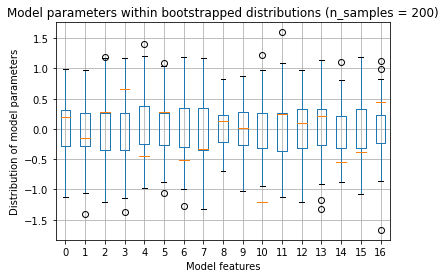

In [ ]:
# Turning "coeffs" into pandas dataframes for ease of manipulation
df = pd.DataFrame(coeffs) 

fig, ax = plt.subplots() # Create the empty figure
medianprops = dict(linewidth=0) # We will remove the median line by setting the line width to 0
conf_int = df.boxplot(medianprops=medianprops) # And we will create a plot of the bootstrap confidence intervals without the medians
plt.boxplot(usermeans) # We superimpose the "usermeans" data onto the current plot
plt.gca().set(
    title="Model parameters within bootstrapped distributions (n_samples = 200)",
    xlabel="Model features",
    ylabel="Distribution of model parameters",
    xticks = list(range(1, 18))
)
plt.show()

The result is a figure with 17 boxplots (one per feature), where the orange lines represent the model parameters (or means) obtained from the original, non-bootrstapped model. The bootsrap procedure essentially gave us a non-parametric distribution of possible datapoints (given scrambled data). With this distribution, we can establish whether a given parameter is within or without the bounds of a confidence interval that would need to be established.

2. Without predictive modeling; using 200 bootstrap iterations, in each drawn bootstrap dataset, subtract the mean volume in an input variable across males from the mean volume across females, for each input variable. Then, plot the 5% and 95% percentiles of the distribution of 200 bootstrapped differences for the purpose of hypothesis testing (dispersion on the y-axis and input variables on the xaxis). Hint: use np.percentile().

In [ ]:
# Importing the packages and the data

from nilearn import datasets
import numpy as np
import pandas as pd
from nilearn.input_data import NiftiLabelsMasker
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_yeo_2011()
masker = NiftiLabelsMasker(labels_img=yeo['thick_17'],
standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F',
dtype=int) #gives 1 for females and 0 for males

import scipy
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/struct.py:774: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [ ]:
# Setting the number of iterations
n_iterations = 200
# Pre-allocating the array where the differences of the 17 features in the 200 models will be appended
differences = []

for i in range(n_iterations):
    input_variables = resample(input_variables, replace=True, n_samples=100) # Scramble the data
    input_variables = scaler.fit_transform(input_variables) # Run the scaler on every iteration
    fem_means = pd.DataFrame(input_variables[output_variable == 1])
    male_means = pd.DataFrame(input_variables [output_variable == 0])
    fem_means = fem_means.mean(axis=0)
    male_means = male_means.mean(axis=0)
    sub = fem_means - male_means   
    differences.append(sub) # Store the differences in the "differences" array
    
differences = np.array(differences)

print(differences.shape)
print(differences[5])
print(differences[55])

(200, 17)
[0.31647897 0.32998827 0.15567802 0.20747502 0.24037397 0.35475904
 0.12818342 0.2081309  0.07201929 0.12035684 0.20232058 0.26377967
 0.17189531 0.20854236 0.15500069 0.22356984 0.15071252]
[-0.2121767  -0.27347735 -0.27469116 -0.26022255 -0.13451208 -0.22067136
 -0.1471824  -0.04090686 -0.27676728 -0.23583126 -0.09464976 -0.18795851
 -0.04508962 -0.24738991 -0.27186355 -0.15748416 -0.10759777]


The result is a numpy array containing 200 bootrsap samples (rows), where every column reflects the difference between the mean value for females minus the mean value for males within that column. We are now ready to plot the percentiles: 

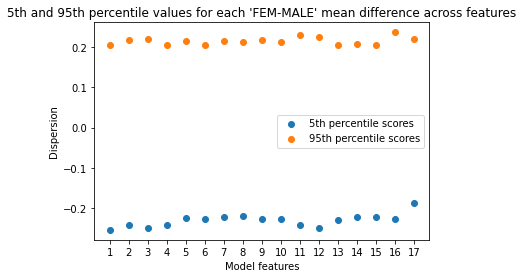

In [ ]:
x = list(range(1, 18))
plt.scatter(x,percentiles_5)
plt.scatter(x,percentiles_95)
plt.legend(labels=("5th percentile scores", "95th percentile scores"))
plt.gca().set(
    title="5th and 95th percentile values for each 'FEM-MALE' mean difference across features",
    xlabel="Model features",
    ylabel="Dispersion",
    xticks = list(range(1, 18))
)
plt.show()

3. Define the training dataset as the first 80 of the 100 subjects, then draw 200 bootstrap samples of this training dataset. On each of the 200 bootstrap samples, train a logistic regression model sklearn.linear_model.LogisticRegression(hyperparameter set to 1.0) to distinguish male versus female participants. Then, building on those 200 fitted models, improve the prediction performance on the remaining subjects as testing data (unseen 20% of the 100 subjects) by majority vote (i.e., select the most common class) across the 200 bootstrapped logistic regression models. Report this average classification performance (% number, no plot).

In [ ]:
# Importing the packages and the data

from nilearn import datasets
import numpy as np
import pandas as pd
from nilearn.input_data import NiftiLabelsMasker
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_yeo_2011()
masker = NiftiLabelsMasker(labels_img=yeo['thick_17'],
standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F',
dtype=int) #gives 1 for females and 0 for males

import scipy
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/struct.py:774: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [ ]:
X, y = input_variables, output_variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Pre-allocating the array where the coefficients of the 200 models will be appended
predictions = []
# Setting the number of iterations
n_iterations = 200

for i in range(n_iterations):
    X_train = resample(X_train, replace=True, n_samples=80) # X_train is the given bootstrap sample in the current iteration
    X_train = scaler.fit_transform(X_train) # Here we run the scaler on every iteration
    LR_boot = LogisticRegression(max_iter=1e4).fit(X_train,y_train) # We fit the LR model to the current bootstrap sample  coefficients.append(LR_boot.coef_) # Store the coefficients in the "coefficients" array
    score = LR_boot.score(X_train, y_train) # We will also export the score for each bootstrap model (...)
    print('Training accuracy: %.3f (%.3f)' % ((score), std(score))) # (...) and we will print it to make sure every model is different
    X_test = scaler.fit_transform(X_test) # Here we run the scaler on every iteration
    yhat = LR_boot.predict(X_test)
    scores = LR_boot.score(X_test, y_test)
    print('Test accuracy: %.3f (%.3f)' % ((scores), std(scores)))
    predictions.append(yhat)
    print(yhat)

Training accuracy: 0.738 (0.000)
Test accuracy: 0.450 (0.000)
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0]
Training accuracy: 0.738 (0.000)
Test accuracy: 0.400 (0.000)
[1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0]
Training accuracy: 0.688 (0.000)
Test accuracy: 0.250 (0.000)
[1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1]
Training accuracy: 0.713 (0.000)
Test accuracy: 0.450 (0.000)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Training accuracy: 0.750 (0.000)
Test accuracy: 0.550 (0.000)
[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
Training accuracy: 0.750 (0.000)
Test accuracy: 0.350 (0.000)
[1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1]
Training accuracy: 0.725 (0.000)
Test accuracy: 0.400 (0.000)
[1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Training accuracy: 0.713 (0.000)
Test accuracy: 0.400 (0.000)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]
Training accuracy: 0.725 (0.000)
Test accuracy: 0.300 (0.000)
[1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1]
Training accuracy: 0.725 (0.000)
Test accuracy: 0.450 (0.000)
[1

The training model accuracy still hover around 0.7, which is not great. The test model accuracy drops when we try to predict the test set, which indicates that our sample of 20 is most likely much too small. Let's find the majority vote for each of these 20 participants based on all the bootstrap predications and re-compute the test model accuracy:

In [ ]:
predictions = pd.DataFrame(predictions)
majority_vote = predictions.mode()
majority_vote = np.array(majority_vote)
print(majority_vote)

percent_predicted = (np.sum(y_test == majority_vote)/20)*100
percent_predicted

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


45.0

Unfortunately majority voting turned every prediction into a 1 because this was the most common class prediction across all bootstrap samples. Now our total model accuracy is lower than for some bootstrap samples!

4. Define the training dataset as the same 80% of the 100 subjects as in Q3, draw 200 bootstrap samples from this dataset, then train a logistic regression model sklearn.linear_model.LogisticRegression (hyperparameter set to 1.0) to distinguish male versus female participants. Average (np.mean) the 200 different sets of model parameters (.coef_) across the 200 fitted models to better identify the model parameters and plot them as bar plot (x-axis is the 17 input variable, y axis is the single mean-averaged parameter value across the bootstrap iterations). Use these averaged model parameters (coefficients) and the remaining 20% of the 100 subjects as test data in a single logistic regression model to predict male versus female participants using this new predictive model. Report the classification performance averaged across the 20 test subjects (% number, no plot). 

In [ ]:
# Importing the packages and the data

from nilearn import datasets
import numpy as np
import pandas as pd
from nilearn.input_data import NiftiLabelsMasker
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_yeo_2011()
masker = NiftiLabelsMasker(labels_img=yeo['thick_17'],
standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F',
dtype=int) #gives 1 for females and 0 for males

import scipy
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/struct.py:774: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [ ]:
X, y = input_variables, output_variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Pre-allocating the array where the coefficients of the 200 models will be appended
coefficients = []
# Setting the number of iterations
n_iterations = 200

for i in range(n_iterations):
    X_train = resample(X_train, replace=True, n_samples=80) # X_train is the given bootstrap sample in the current iteration
    X_train = scaler.fit_transform(X_train) # Here we run the scaler on every iteration
    LR_boot = LogisticRegression(max_iter=1e4).fit(X_train,y_train) # We fit the LR model to the current bootstrap sample  coefficients.append(LR_boot.coef_) # Store the coefficients in the "coefficients" array
    coefficients.append(LR_boot.coef_)
    score = LR_boot.score(X_train, y_train) # We will also export the score for each bootstrap model (...)
    print('Accuracy: %.3f (%.3f)' % ((score), std(score))) # (...) and we will print it to make sure every model is different

Accuracy: 0.713 (0.000)
Accuracy: 0.725 (0.000)
Accuracy: 0.713 (0.000)
Accuracy: 0.700 (0.000)
Accuracy: 0.713 (0.000)
Accuracy: 0.750 (0.000)
Accuracy: 0.700 (0.000)
Accuracy: 0.700 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.738 (0.000)
Accuracy: 0.700 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.713 (0.000)
Accuracy: 0.738 (0.000)
Accuracy: 0.713 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.700 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.700 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.713 (0.000)
Accuracy: 0.713 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.688 (0.000)
Accuracy: 0.725 

For most bootstrap samples, model accuracy is 0.688, with some exceptions where accuracy reaches 0.7 or slightly above. Let's compute the mean of all coefficient by feature column and plot the result:

In [ ]:
coefficients = np.array(coefficients) # Convert the "coefficients" list into an np.array
coeffs = coefficients.squeeze() # Remove the extraneous axis
coef_mean = np.mean(coeffs, axis = 0)

<function matplotlib.pyplot.show(*args, **kw)>

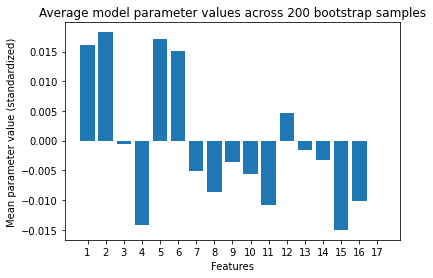

In [ ]:
x = list(range(1, 18))
plt.bar(x, coef_mean)
plt.gca().set(
    title= "Average model parameter values across 200 bootstrap samples",
    xlabel="Features",
    ylabel="Mean parameter value (standardized)",
    xticks = list(range(1, 18)),
)
plt.show

Now let's see if inputting these coefficients into LR_boot.coef_ will boost our prediction accuracy in the test set:

In [ ]:
# We turn "coef_mean" to a 2D np.array  
coef_mean = np.array(coef_mean, ndmin=2)
LR_boot.coef_ = coef_mean # We pass "coef_mean" into the LR_boot.coef_ attribute

# Print both np arrays to make sure they're identical
print(coef_mean) 
print(LR_boot.coef_) 

[[ 1.61324066e-02  1.82437676e-02 -4.81566576e-04 -1.41644549e-02
   1.71207280e-02  1.50068462e-02 -5.13574720e-03 -8.57994668e-03
  -3.61343275e-03 -5.58169070e-03 -1.07949218e-02  4.72787826e-03
  -1.62358389e-03 -3.28166820e-03 -1.50196486e-02 -1.00788296e-02
  -2.42457332e-05]]
[[ 1.61324066e-02  1.82437676e-02 -4.81566576e-04 -1.41644549e-02
   1.71207280e-02  1.50068462e-02 -5.13574720e-03 -8.57994668e-03
  -3.61343275e-03 -5.58169070e-03 -1.07949218e-02  4.72787826e-03
  -1.62358389e-03 -3.28166820e-03 -1.50196486e-02 -1.00788296e-02
  -2.42457332e-05]]


In [ ]:
# We're ready to run the predictions on the test set
yhat = LR_boot.predict(X_test) # We define the model and store its prediction as "yhat"
score = LR_boot.score(X_test, y_test) # We store the scores
print('Accuracy: %.3f (%.3f)' % ((score), std(score))) # We print the scores
print(LR_boot.coef_) # We re-print the coefficients to make sure they're the same as in the previous cell

Accuracy: 0.450 (0.000)
[[ 1.61324066e-02  1.82437676e-02 -4.81566576e-04 -1.41644549e-02
   1.71207280e-02  1.50068462e-02 -5.13574720e-03 -8.57994668e-03
  -3.61343275e-03 -5.58169070e-03 -1.07949218e-02  4.72787826e-03
  -1.62358389e-03 -3.28166820e-03 -1.50196486e-02 -1.00788296e-02
  -2.42457332e-05]]


Model accuracy didn't improve much after passing the mean coefficients. This is likely due to the fact that the sample size is too small.

5. Draw 200 bootstrap samples from all 100 subjects and fit a logistic regression model on each bootstrap sample. Then, perform cross-validation (CV) via out-ofbag (OOB) evaluation on the remaining (roughly ⅓) unseen (unsampled) subjects in each bootstrap iteration (recall lecture slides: only ~ 2/3 of the original dataset shows up in the bootstrap samples). Plot a scatterplot of the OOB CV accuracy for each bootstrap iteration (x-axis is the 200 iterations, y-axis is the OOB accuracy of the corresponding model).

In [ ]:
# Importing the packages and the data

from nilearn import datasets
import numpy as np
import pandas as pd
from nilearn.input_data import NiftiLabelsMasker
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_yeo_2011()
masker = NiftiLabelsMasker(labels_img=yeo['thick_17'],
standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F',
dtype=int) #gives 1 for females and 0 for males

import scipy
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/struct.py:774: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [ ]:
# Setting the number of iterations
n_iterations = 200

# Importing the mlxtend packagre for OOB bootsrapping
from mlxtend.evaluate import BootstrapOutOfBag
oob = BootstrapOutOfBag(n_splits=200)

# Pre-allocating an empty list where we will collect the oob accuracy scores
oob_acc = []

# We're ready to iterate through the 200 bootstraps samples and collect the oob scores
for i in range(n_iterations):
    X_train = resample(input_variables, replace=True, n_samples=100) # X_train is the given bootstrap sample in the current iteration
    X_train = scaler.fit_transform(X_train) # Here we run the scaler on every iteration
    y_train = output_variable
    LR_boot = LogisticRegression(max_iter=1e4).fit(X_train,y_train) # We fit the LR model to the current bootstrap sample  coefficients.append(LR_boot.coef_) # Store the coefficients in the "coefficients" array
    score = LR_boot.score(X_train, y_train) # We will also export the score for each bootstrap model (...)
    print('Accuracy: %.3f (%.3f)' % ((score), std(score))) # (...) and we will print it to make sure every model is different
    oob_scores = cross_val_score(LR_boot, X_train, y_train, cv=oob)
    print('OOB: %.3f (%.3f)' % (mean(oob_scores), std(oob_scores)))
    oob_acc.append(oob_scores)

Accuracy: 0.680 (0.000)
OOB: 0.525 (0.065)
Accuracy: 0.670 (0.000)
OOB: 0.537 (0.067)
Accuracy: 0.720 (0.000)
OOB: 0.579 (0.075)
Accuracy: 0.660 (0.000)
OOB: 0.543 (0.069)
Accuracy: 0.630 (0.000)
OOB: 0.523 (0.065)
Accuracy: 0.710 (0.000)
OOB: 0.576 (0.072)
Accuracy: 0.660 (0.000)
OOB: 0.575 (0.061)
Accuracy: 0.670 (0.000)
OOB: 0.547 (0.072)
Accuracy: 0.700 (0.000)
OOB: 0.559 (0.071)
Accuracy: 0.660 (0.000)
OOB: 0.578 (0.068)
Accuracy: 0.660 (0.000)
OOB: 0.506 (0.077)
Accuracy: 0.780 (0.000)
OOB: 0.654 (0.074)
Accuracy: 0.700 (0.000)
OOB: 0.601 (0.065)
Accuracy: 0.720 (0.000)
OOB: 0.576 (0.073)
Accuracy: 0.680 (0.000)
OOB: 0.558 (0.064)
Accuracy: 0.710 (0.000)
OOB: 0.567 (0.064)
Accuracy: 0.690 (0.000)
OOB: 0.541 (0.075)
Accuracy: 0.660 (0.000)
OOB: 0.574 (0.072)
Accuracy: 0.720 (0.000)
OOB: 0.576 (0.070)
Accuracy: 0.650 (0.000)
OOB: 0.537 (0.066)
Accuracy: 0.680 (0.000)
OOB: 0.540 (0.070)
Accuracy: 0.700 (0.000)
OOB: 0.573 (0.071)
Accuracy: 0.650 (0.000)
OOB: 0.546 (0.071)
Accuracy: 0

Now that we have our oob accuracy scores, we're ready to display them graphically on a scatterplot:

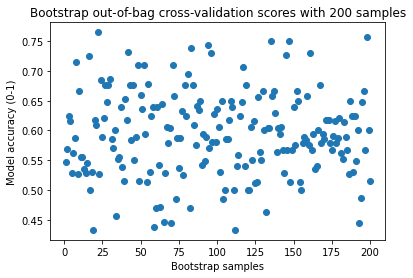

In [ ]:
x = list(range(1, 201))
plt.scatter(x,oob_scores)
plt.gca().set(
    title= "Bootstrap out-of-bag cross-validation scores with 200 samples",
    xlabel= "Bootstrap samples",
    ylabel="Model accuracy (0-1)"
)
plt.show()

Dataset B (regression): for the second set of 5 small programming tasks, use the Haxby dataset provided by the nilearn package, which can be downloaded using the code below. This is a dataset of functional brain scans (functional MRI measurements from one subject) acquired while individuals watched people’s faces or house pictures.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':


The only relevant horizontal brain slice has 739 voxels.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


The only relevant horizontal brain slice has 739 voxels.


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:1333: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])


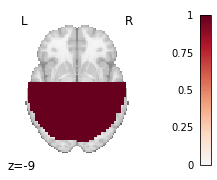

In [ ]:
from nilearn import datasets
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from matplotlib import pylab as plt

haxby_dataset = datasets.fetch_haxby(subjects=1)
mask_filename = haxby_dataset.mask
mask_img = nib.load(mask_filename)
process_mask = mask_img.get_data()
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0 # zero out anterior “half” of the brain
process_mask_img = new_img_like(mask_img, process_mask)

from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(smoothing_fwhm=8,
mask_img=process_mask_img)
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions.isin(['face', 'house'])
fmri_masked = fmri_masked[condition_mask]
output_variable = np.array(conditions[condition_mask] == 'face',
dtype=int)

print('The only relevant horizontal brain slice has %i voxels.' %
process_mask[..., picked_slice].sum())

from nilearn import datasets
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from matplotlib import pylab as plt

haxby_dataset = datasets.fetch_haxby(subjects=1)
mask_filename = haxby_dataset.mask
mask_img = nib.load(mask_filename)
process_mask = mask_img.get_data()
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0 # zero out anterior “half” of the brain
process_mask_img = new_img_like(mask_img, process_mask)

from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(smoothing_fwhm=8,
mask_img=process_mask_img)
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions.isin(['face', 'house'])
fmri_masked = fmri_masked[condition_mask]
output_variable = np.array(conditions[condition_mask] == 'face',
dtype=int)

print('The only relevant horizontal brain slice has %i voxels.' %
process_mask[..., picked_slice].sum())

#plot that slice to get an impression of where the input variables are in the brain 
plot_stat_map(process_mask_img, cut_coords=[-9],
display_mode="z", cmap=plt.cm.RdBu_r)

Note: since there are many more input variables in this dataset, for ll of the following questions only generate plots of the first 17 input variables (your models should still be trained using all input ariables). For Q8 and Q9 use an 80/20% train/test split.

6. analogous to task 1 but using sklearn.linear_model.Ridge(default hyperparameters) instead of logistic regression, since the target is now continuous.

  Use sklearn.linear_model.Ridge(default hyperparameters) trained on all input_variables to perform uncertainty estimation. Draw 200 bootstrap samples from the dataset, and for each of these bootstrap datasets, fit your model on all 216 subjects (you will train 200 models). Plot the distribution of model parameters(.coef_)using pyplot.boxplot(). The distribution of the model parameters should be on the y-axis and the first 17 input variables on the x axis; the mean of each box is the original point estimate of the model coefficient (i.e., the original dataset, not the bootstrap data). 

In [ ]:
input_variables = fmri_masked
input_variables.shape

(216, 739)

In [ ]:
import scipy
from numpy import mean
from numpy import std
from sklearn.linear_model import Ridge
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
# Let's create one bootstrap sample containing 216 observations to make sure we have everything we need
boot = resample(input_variables, replace=True, n_samples=216)
print (boot.shape)

(216, 739)


Looks like the size of our "boot" sample is correct, because it is the same as the original data. But we will need 200 of these samples, so let's make use of a for loop to create them iteratively:

In [ ]:
# Setting the number of iterations
n_iterations = 200
# Pre-allocating the array where the coefficients of the 200 models will be appended
coefficients = []

for i in range(n_iterations):
    X_train = resample(input_variables, replace=True, n_samples=216) # X_train is the given bootstrap sample in the current iteration
    X_train = scaler.fit_transform(X_train) # Here we run the scaler on every iteration
    y_train = output_variable # y_train will remain the same as the original sample across iterations
    LinReg_boot = Ridge().fit(X_train,y_train) # We fit the LR model to the current bootstrap sample
    coefficients.append(LinReg_boot.coef_) # Store the coefficients in the "coefficients" array
    score = LinReg_boot.score(X_train, y_train) # We will also export the score for each bootstrap model (...)
    print('Accuracy: %.3f (%.3f)' % ((score), std(score))) # (...) and we will print it to make sure every model is different

Accuracy: 0.587 (0.000)
Accuracy: 0.536 (0.000)
Accuracy: 0.631 (0.000)
Accuracy: 0.551 (0.000)
Accuracy: 0.635 (0.000)
Accuracy: 0.629 (0.000)
Accuracy: 0.633 (0.000)
Accuracy: 0.546 (0.000)
Accuracy: 0.643 (0.000)
Accuracy: 0.648 (0.000)
Accuracy: 0.645 (0.000)
Accuracy: 0.564 (0.000)
Accuracy: 0.666 (0.000)
Accuracy: 0.653 (0.000)
Accuracy: 0.673 (0.000)
Accuracy: 0.652 (0.000)
Accuracy: 0.625 (0.000)
Accuracy: 0.583 (0.000)
Accuracy: 0.521 (0.000)
Accuracy: 0.608 (0.000)
Accuracy: 0.617 (0.000)
Accuracy: 0.722 (0.000)
Accuracy: 0.534 (0.000)
Accuracy: 0.632 (0.000)
Accuracy: 0.591 (0.000)
Accuracy: 0.677 (0.000)
Accuracy: 0.543 (0.000)
Accuracy: 0.607 (0.000)
Accuracy: 0.618 (0.000)
Accuracy: 0.666 (0.000)
Accuracy: 0.564 (0.000)
Accuracy: 0.620 (0.000)
Accuracy: 0.641 (0.000)
Accuracy: 0.605 (0.000)
Accuracy: 0.633 (0.000)
Accuracy: 0.586 (0.000)
Accuracy: 0.628 (0.000)
Accuracy: 0.611 (0.000)
Accuracy: 0.728 (0.000)
Accuracy: 0.587 (0.000)
Accuracy: 0.587 (0.000)
Accuracy: 0.523 

Overall model accuracies are indeed different from each other, which is good, and they seem to hover around the 0.6 value. Let's compute the model accuracy for the model with the original data to see if it's better than what we get with bootstrap samples:

In [ ]:
input_variables = scaler.fit_transform(input_variables) # We replicate the pipeline by first standardizing the data 
LinReg = Ridge().fit(input_variables,output_variable)
score = LinReg.score(input_variables, output_variable)
print('Accuracy: %.3f (%.3f)' % ((score), std(score)))
usermeans = LinReg.coef_ # We will store the model paramaters in a variable called "usermeans" to be used later

Accuracy: 0.996 (0.000)


Looks like our model accuracy is very good, and certainly much better than what we got with the 200 dummy samples. This is because the bootstrapped samples were created using 'sampling with replacement', which makes the data in each sample comparatively less rich than the original data. However, this will do just fine for our purposes, so let's reshape the "coefficients" list into an np.array and remove any extra dimensions:

In [ ]:
coefficients = np.array(coefficients) # Convert the "coefficients" list into an np.array
coeffs = coefficients.squeeze() # Remove the extraneous axis
print(coeffs.shape) # We will make sure we have 200 instances of 739 features

(200, 739)


The reshaping worked. Now that we have the same number of dimensions as the array we called "usermeans", we are ready to produce a boxplot. But first, we need to remove columns 18 through 739:

In [ ]:
usermeans.shape

(739,)

In [ ]:
coeffs_trim = coeffs[:,0:17]
usermeans_trim = usermeans[0:17,]

print(coeffs_trim.shape)
print(usermeans_trim.shape)

(200, 17)
(17,)


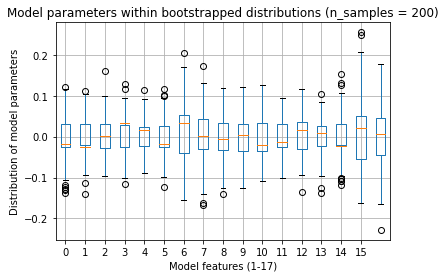

In [ ]:
# Turning "coeffs" into pandas dataframes for ease of manipulation
df = pd.DataFrame(coeffs_trim)
df2 = pd.DataFrame(usermeans_trim)
x =  list(range(1, 17))

fig, ax = plt.subplots() # Create the empty figure
medianprops = dict(linewidth=0) # We will remove the median line by setting the line width to 0
df.boxplot(medianprops=medianprops) # And we will create a plot of the bootstrap confidence intervals without the medians
plt.boxplot(df2) # We superimpose the "usermeans" data onto the current plot
plt.gca().set(
    title="Model parameters within bootstrapped distributions (n_samples = 200)",
    xlabel="Model features (1-17)",
    ylabel="Distribution of model parameters",
    xticks = x
)
plt.show()

The result is a figure with 17 boxplots (one per feature), where the range lines represent the model parameters (or means) obtained from the original, non-bootrstapped model. The bootsrap procedure essentially gave us a non-parametric distribution of possible datapoints (given scrambled data). With this distribution, we can establish whether a given parameter is within or without the bounds of a confidence interval which would need to be established a priori. 

7. analogous to task 2 but using sklearn.linear_model.Ridge(default hyperparameters).

Without predictive modeling; using 200 bootstrap iterations, in each drawn bootstrap dataset, subtract the mean volume in an input variable across males from the mean volume across females, for each input variable. Then, plot the 5% and 95% percentiles of the distribution of 200 bootstrapped differences for the purpose of hypothesis testing (dispersion on the y-axis and input variables on the xaxis). Hint: use np.percentile().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':


The only relevant horizontal brain slice has 739 voxels.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


The only relevant horizontal brain slice has 739 voxels.


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:1333: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])


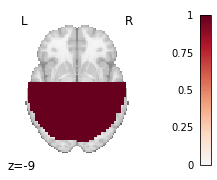

In [ ]:
from nilearn import datasets
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from matplotlib import pylab as plt

haxby_dataset = datasets.fetch_haxby(subjects=1)
mask_filename = haxby_dataset.mask
mask_img = nib.load(mask_filename)
process_mask = mask_img.get_data()
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0 # zero out anterior “half” of the brain
process_mask_img = new_img_like(mask_img, process_mask)

from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(smoothing_fwhm=8,
mask_img=process_mask_img)
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions.isin(['face', 'house'])
fmri_masked = fmri_masked[condition_mask]
output_variable = np.array(conditions[condition_mask] == 'face',
dtype=int)

print('The only relevant horizontal brain slice has %i voxels.' %
process_mask[..., picked_slice].sum())

from nilearn import datasets
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from matplotlib import pylab as plt

haxby_dataset = datasets.fetch_haxby(subjects=1)
mask_filename = haxby_dataset.mask
mask_img = nib.load(mask_filename)
process_mask = mask_img.get_data()
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0 # zero out anterior “half” of the brain
process_mask_img = new_img_like(mask_img, process_mask)

from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(smoothing_fwhm=8,
mask_img=process_mask_img)
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions.isin(['face', 'house'])
fmri_masked = fmri_masked[condition_mask]
output_variable = np.array(conditions[condition_mask] == 'face',
dtype=int)

print('The only relevant horizontal brain slice has %i voxels.' %
process_mask[..., picked_slice].sum())

#plot that slice to get an impression of where the input variables are in the brain 
plot_stat_map(process_mask_img, cut_coords=[-9],
display_mode="z", cmap=plt.cm.RdBu_r)

In [ ]:
input_variables = fmri_masked
input_variables_trim = input_variables[:,0:17] # We will trim the input_data because we're not going to compute differences across all features. Just the first 17.
input_variables_trim.shape

(216, 17)

In [ ]:
import scipy
from numpy import mean
from numpy import std
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
# Setting the number of iterations
n_iterations = 200
# Pre-allocating the array where the differences of the 17 features in the 200 models will be appended
differences = []

for i in range(n_iterations):
    input_variables_trim = resample(input_variables_trim, replace=True, n_samples=216) # Scramble the data
    input_variables_trim = scaler.fit_transform(input_variables_trim) # Run the scaler on every iteration
    face_means = pd.DataFrame(input_variables_trim[output_variable == 1])
    house_means = pd.DataFrame(input_variables_trim[output_variable == 0])
    face_means = face_means.mean(axis=0)
    house_means = house_means.mean(axis=0)
    sub = face_means - house_means   
    differences.append(sub) # Store the differences in the "differences" array
    
differences = np.array(differences)

print(differences.shape)
print(differences[5])
print(differences[55])

(200, 17)
[ 0.13252473  0.11196524  0.10737114  0.10858215  0.1060061   0.11274682
  0.15090537  0.17619309  0.17279893  0.13621892  0.11813287  0.12133473
  0.1212146   0.09811439  0.0989452  -0.06468579 -0.05026523]
[-0.03230636 -0.04429865 -0.04351338 -0.03975179 -0.03891551 -0.04030026
 -0.00082624 -0.00028844  0.03221985  0.06096209 -0.00038623 -0.0197193
 -0.01292908 -0.00904719 -0.01725051  0.03479417  0.0722026 ]


The result is a numpy array containing 200 bootrsap samples (rows), where every column reflects the difference between the mean value for females minus the mean value for males within that column. We are now ready to plot the percentiles: 

In [ ]:
percentiles_5 = np.percentile(differences,5,0)
percentiles_95 = np.percentile(differences,95,0)

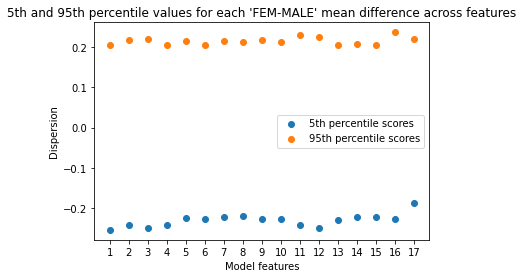

In [ ]:
x = list(range(1, 18))
plt.scatter(x,percentiles_5)
plt.scatter(x,percentiles_95)
plt.legend(labels=("5th percentile scores", "95th percentile scores"))
plt.gca().set(
    title="5th and 95th percentile values for each 'FEM-MALE' mean difference across features",
    xlabel="Model features",
    ylabel="Dispersion",
    xticks = list(range(1, 18))
)
plt.show()

8. analogous to task 3 but using sklearn.linear_model.Ridge(default hyperparameters) and using the coefficient of determination (the default .score() metric for Ridge) instead of accuracy.

Define the training dataset as the first 80 of the 100 subjects, then raw 200 bootstrap samples of this training dataset. On each of the 200 bootstrap samples, train a ridge regression model sklearn.linear_model.Ridge(hyperparameter set to 1.0) to distinguish faces versus houses . Then, building on those 200 fitted models, improve the prediction performance on the remaining subjects as testing data (unseen 20% of the 100 subjects) by majority vote (i.e., select the most common class) across the 200 bootstrapped logistic regression models. Report the  default .score() metric for Ridge instead of accuracy.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':


The only relevant horizontal brain slice has 739 voxels.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


The only relevant horizontal brain slice has 739 voxels.


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:1333: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])


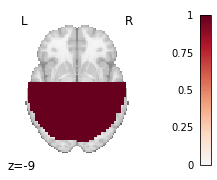

In [ ]:
from nilearn import datasets
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from matplotlib import pylab as plt

haxby_dataset = datasets.fetch_haxby(subjects=1)
mask_filename = haxby_dataset.mask
mask_img = nib.load(mask_filename)
process_mask = mask_img.get_data()
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0 # zero out anterior “half” of the brain
process_mask_img = new_img_like(mask_img, process_mask)

from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(smoothing_fwhm=8,
mask_img=process_mask_img)
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions.isin(['face', 'house'])
fmri_masked = fmri_masked[condition_mask]
output_variable = np.array(conditions[condition_mask] == 'face',
dtype=int)

print('The only relevant horizontal brain slice has %i voxels.' %
process_mask[..., picked_slice].sum())

from nilearn import datasets
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from matplotlib import pylab as plt

haxby_dataset = datasets.fetch_haxby(subjects=1)
mask_filename = haxby_dataset.mask
mask_img = nib.load(mask_filename)
process_mask = mask_img.get_data()
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0 # zero out anterior “half” of the brain
process_mask_img = new_img_like(mask_img, process_mask)

from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(smoothing_fwhm=8,
mask_img=process_mask_img)
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions.isin(['face', 'house'])
fmri_masked = fmri_masked[condition_mask]
output_variable = np.array(conditions[condition_mask] == 'face',
dtype=int)

print('The only relevant horizontal brain slice has %i voxels.' %
process_mask[..., picked_slice].sum())

#plot that slice to get an impression of where the input variables are in the brain 
plot_stat_map(process_mask_img, cut_coords=[-9],
display_mode="z", cmap=plt.cm.RdBu_r)

In [ ]:
input_variables = fmri_masked
input_variables_trim = input_variables[:,0:17] # We will trim the input_data because we don't want to compute differences across all features. Just the first 17.
input_variables_trim.shape

(216, 17)

In [ ]:
import scipy
from numpy import mean
from numpy import std
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
from sklearn.model_selection import train_test_split
X, y = input_variables_trim, output_variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Pre-allocating the array where the coefficients of the 200 models will be appended
predictions = []
# Setting the number of iterations
n_iterations = 200

for i in range(n_iterations):
    X_train = resample(X_train, replace=True, n_samples=172) # X_train is the given bootstrap sample in the current iteration
    X_train = scaler.fit_transform(X_train) # Here we run the scaler on every iteration
    LR_boot = Ridge().fit(X_train,y_train) # We fit the LR model to the current bootstrap sample  coefficients.append(LR_boot.coef_) # Store the coefficients in the "coefficients" array
    score = LR_boot.score(X_train, y_train) # We will also export the score for each bootstrap model (...)
    print('Coefficient of determination: training: %.3f' % ((score))) # (...) and we will print it to make sure every model is different
    X_test = scaler.fit_transform(X_test)
    yhat = LR_boot.predict(X_test)
    scores = LR_boot.score(X_test, y_test)
    print('Coefficient of determination: prediction: %.3f' % ((scores)))
    predictions.append(yhat)

Coefficient of determination: training: 0.093
Coefficient of determination: prediction: -0.068
Coefficient of determination: training: 0.070
Coefficient of determination: prediction: -0.034
Coefficient of determination: training: 0.031
Coefficient of determination: prediction: -0.046
Coefficient of determination: training: 0.064
Coefficient of determination: prediction: -0.049
Coefficient of determination: training: 0.051
Coefficient of determination: prediction: -0.232
Coefficient of determination: training: 0.072
Coefficient of determination: prediction: -0.274
Coefficient of determination: training: 0.067
Coefficient of determination: prediction: -0.067
Coefficient of determination: training: 0.083
Coefficient of determination: prediction: -0.124
Coefficient of determination: training: 0.054
Coefficient of determination: prediction: -0.165
Coefficient of determination: training: 0.052
Coefficient of determination: prediction: -0.093
Coefficient of determination: training: 0.123
Coef

Model accuracies, given by the coefficient of determination, are quite bad because they're hovering around 0, but at least they're within the theoretical range of -1 to 1. This could be due to the fact that we're using a regressor for classification purposes.

In [ ]:
predictions = pd.DataFrame(predictions)
majority_vote = predictions.mode()
majority_vote = np.array(majority_vote)

In [ ]:
y_test = np.array(y_test)
u = ((y_test - majority_vote)** 2).sum()
v = ((y_test - majority_vote.mean()) ** 2).sum()
R2 = (1-(u/v))

In [ ]:
# We print the total coefficient of determination
print('Overall coefficient of determination: %.3f' % ((R2)))

Overall coefficient of determination: 0.000


Model accuracy, given by the coefficient of determination, is essentially 0, which is very bad. This might be due to the fact that Ridge regression is not the right algorithm for classification of discrete variables (face vs house).

9. analogous to task 4 but using sklearn.linear_model.Ridge(default hyperparameters) and using the coefficient of determination instead of accuracy.

Define the training dataset as the same 80% of the 100 subjects as in Q8, draw 200 bootstrap samples from this dataset, then train a Ridge regression model sklearn.linear_model.Ridge (default hyperparameters) to distinguish faces vs houses. Average (np.mean) the 200 different sets of model parameters (.coef_) across the 200 fitted models to better identify the model parameters and plot them on a bar plot (x-axis is the 17 input variable, y axis is the single mean-averaged parameter value across the bootstrap iterations). Use these averaged model parameters (coefficients) and the remaining 20% of the 100 subjects as test data in a single logistic regression model to predict male versus female participants using this new predictive model. Report the classification performance using the coefficient of determination instead of accuracy.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':


The only relevant horizontal brain slice has 739 voxels.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


The only relevant horizontal brain slice has 739 voxels.


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:1333: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])


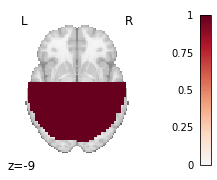

In [ ]:
from nilearn import datasets
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from matplotlib import pylab as plt

haxby_dataset = datasets.fetch_haxby(subjects=1)
mask_filename = haxby_dataset.mask
mask_img = nib.load(mask_filename)
process_mask = mask_img.get_data()
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0 # zero out anterior “half” of the brain
process_mask_img = new_img_like(mask_img, process_mask)

from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(smoothing_fwhm=8,
mask_img=process_mask_img)
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions.isin(['face', 'house'])
fmri_masked = fmri_masked[condition_mask]
output_variable = np.array(conditions[condition_mask] == 'face',
dtype=int)

print('The only relevant horizontal brain slice has %i voxels.' %
process_mask[..., picked_slice].sum())

from nilearn import datasets
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from matplotlib import pylab as plt

haxby_dataset = datasets.fetch_haxby(subjects=1)
mask_filename = haxby_dataset.mask
mask_img = nib.load(mask_filename)
process_mask = mask_img.get_data()
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0 # zero out anterior “half” of the brain
process_mask_img = new_img_like(mask_img, process_mask)

from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(smoothing_fwhm=8,
mask_img=process_mask_img)
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions.isin(['face', 'house'])
fmri_masked = fmri_masked[condition_mask]
output_variable = np.array(conditions[condition_mask] == 'face',
dtype=int)

print('The only relevant horizontal brain slice has %i voxels.' %
process_mask[..., picked_slice].sum())

#plot that slice to get an impression of where the input variables are in the brain 
plot_stat_map(process_mask_img, cut_coords=[-9],
display_mode="z", cmap=plt.cm.RdBu_r)

In [ ]:
input_variables = fmri_masked
input_variables_trim = input_variables[:,0:17] # We will trim the input_data because we're not going to compute coefficients for all features. Just the first 17.
input_variables_trim.shape

(216, 17)

In [ ]:
import scipy
from numpy import mean
from numpy import std
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
X, y = input_variables_trim, output_variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Pre-allocating the array where the coefficients of the 200 models will be appended
coefficients = []
# Setting the number of iterations
n_iterations = 200

for i in range(n_iterations):
    X_train = resample(X_train, replace=True, n_samples=172) # X_train is the given bootstrap sample in the current iteration
    X_train = scaler.fit_transform(X_train) # Here we run the scaler on every iteration
    LR_boot = Ridge().fit(X_train,y_train) # We fit the LR model to the current bootstrap sample  coefficients.append(LR_boot.coef_) # Store the coefficients in the "coefficients" array
    coefficients.append(LR_boot.coef_)
    score = LR_boot.score(X_train, y_train) # We will also export the score for each bootstrap model (...)
    print('Coefficient of determination training: %.3f' % ((score))) # (...) and we will print it to make sure every model is different

Coefficient of determination training: 0.062
Coefficient of determination training: 0.051
Coefficient of determination training: 0.063
Coefficient of determination training: 0.033
Coefficient of determination training: 0.044
Coefficient of determination training: 0.210
Coefficient of determination training: 0.032
Coefficient of determination training: 0.048
Coefficient of determination training: 0.036
Coefficient of determination training: 0.023
Coefficient of determination training: 0.098
Coefficient of determination training: 0.068
Coefficient of determination training: 0.073
Coefficient of determination training: 0.049
Coefficient of determination training: 0.175
Coefficient of determination training: 0.070
Coefficient of determination training: 0.044
Coefficient of determination training: 0.034
Coefficient of determination training: 0.021
Coefficient of determination training: 0.066
Coefficient of determination training: 0.057
Coefficient of determination training: 0.059
Coefficien

In [ ]:
coefficients = np.array(coefficients) # Convert the "coefficients" list into an np.array
coef_mean = np.mean(coefficients, axis = 0)
coef_mean

array([ 0.00010558,  0.00034246, -0.00082785, -0.00164694, -0.00213851,
        0.00390616,  0.00059033,  0.00045356,  0.00430352,  0.0054862 ,
       -0.00238411, -0.00159786,  0.00248417,  0.00099441, -0.00264565,
        0.00014075, -0.00857813], dtype=float32)

<function matplotlib.pyplot.show(*args, **kw)>

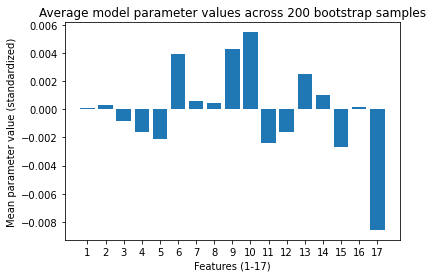

In [ ]:
x = list(range(1, 18))
plt.bar(x, coef_mean)
plt.gca().set(
    title= "Average model parameter values across 200 bootstrap samples",
    xlabel="Features (1-17)",
    ylabel="Mean parameter value (standardized)",
    xticks = list(range(1, 18)),
)
plt.show

In [ ]:
LR_boot.coef_ = coef_mean
yhat = LR_boot.predict(X_test)
scores = LR_boot.score(X_test, y_test)
print('Overall coefficient of determination: %.3f' % ((scores)))

Overall coefficient of determination: -0.204


Our overall coefficient of determination is somewhat better after averaging the coefficients from 200 bootstrap samples than when we used majority voting in the previous exercise. However, in general terms the model accuracy is still very low, most likely due to the fact that we're using an improper algorithm for classification. 

10. analogous to task 5 but using sklearn.linear_model.Ridge(default hyperparameters) and using the coefficient of determination instead of accuracy.

Draw 200 bootstrap samples from all 216 subjects and fit a Ridge regression model on each bootstrap sample. Then, perform cross-validation (CV) via out-of-bag (OOB) evaluation on the remaining (roughly ⅓) unseen (unsampled) subjects in each bootstrap iteration (recall lecture slides: only ~ 2/3 of the original dataset shows up in the bootstrap samples). Plot a scatterplot of the OOB CV accuracy for each bootstrap iteration (x-axis is the 200 iterations, y-axis is the OOB accuracy of the corresponding model).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':


The only relevant horizontal brain slice has 739 voxels.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


The only relevant horizontal brain slice has 739 voxels.


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:1333: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])


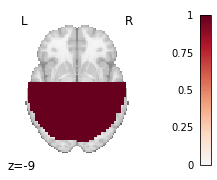

In [ ]:
from nilearn import datasets
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from matplotlib import pylab as plt

haxby_dataset = datasets.fetch_haxby(subjects=1)
mask_filename = haxby_dataset.mask
mask_img = nib.load(mask_filename)
process_mask = mask_img.get_data()
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0 # zero out anterior “half” of the brain
process_mask_img = new_img_like(mask_img, process_mask)

from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(smoothing_fwhm=8,
mask_img=process_mask_img)
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions.isin(['face', 'house'])
fmri_masked = fmri_masked[condition_mask]
output_variable = np.array(conditions[condition_mask] == 'face',
dtype=int)

print('The only relevant horizontal brain slice has %i voxels.' %
process_mask[..., picked_slice].sum())

from nilearn import datasets
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from matplotlib import pylab as plt

haxby_dataset = datasets.fetch_haxby(subjects=1)
mask_filename = haxby_dataset.mask
mask_img = nib.load(mask_filename)
process_mask = mask_img.get_data()
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0 # zero out anterior “half” of the brain
process_mask_img = new_img_like(mask_img, process_mask)

from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(smoothing_fwhm=8,
mask_img=process_mask_img)
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions.isin(['face', 'house'])
fmri_masked = fmri_masked[condition_mask]
output_variable = np.array(conditions[condition_mask] == 'face',
dtype=int)

print('The only relevant horizontal brain slice has %i voxels.' %
process_mask[..., picked_slice].sum())

#plot that slice to get an impression of where the input variables are in the brain 
plot_stat_map(process_mask_img, cut_coords=[-9],
display_mode="z", cmap=plt.cm.RdBu_r)

In [ ]:
input_variables = fmri_masked # This time around we will use the entire feature space because we're not asked to plot the features
input_variables.shape #  Let's make sure we have 739 features

(216, 739)

In [ ]:
import scipy
from numpy import mean
from numpy import std
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
# Setting the number of iterations
n_iterations = 200

# Importing the Out of Bag bootsrap package called mlxtend
from mlxtend.evaluate import BootstrapOutOfBag
oob = BootstrapOutOfBag(n_splits=200)

# Pre-allocating an empty list called "oob_acc" which will collect the OOB coefficients of determination
oob_acc = []

# We're ready to run the for loop that will iterate our model over 200 bootrsap samples
for i in range(n_iterations):
    X_train = resample(input_variables, replace=True, n_samples=216) # X_train is the given bootstrap sample in the current iteration
    X_train = scaler.fit_transform(X_train) # Here we run the scaler on every iteration
    y_train = output_variable # We need to specify that y_train is the output variable because we didn't split the data this time
    LR_boot = Ridge().fit(X_train,y_train) # We fit the LR model to the current bootstrap sample  
    score = LR_boot.score(X_train, y_train) # We will also save the score for each bootstrap model 
    oob_scores = cross_val_score(LR_boot, X_train, y_train, cv=oob) # As well as the score for every OOB bootstrap model...
    oob_acc.append(oob_scores) # ... and store it in the pre-allocated "oob_acc"

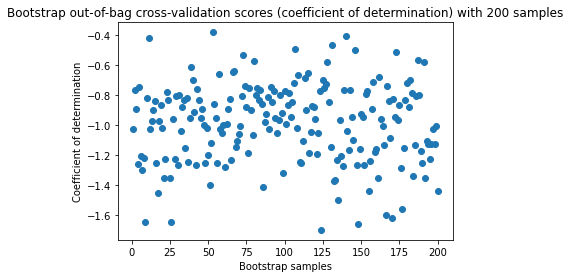

In [ ]:
# We're ready to make a scatterplot of model accuracy as indexed by the coefficient of determination (y-axis) by bootstrap sample (x-axis)
x = list(range(1, 201))
plt.scatter(x,oob_scores)
plt.gca().set(
    title= "Bootstrap out-of-bag cross-validation scores (coefficient of determination) with 200 samples",
    xlabel= "Bootstrap samples",
    ylabel="Coefficient of determination"
)
plt.show()